In [1]:
from signals import *
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
from indicators import SMA, SuperTrend
from matplotlib import pyplot as plt
from math import exp, log

%matplotlib inline

df = load_ticker("EURUSD", 60)
begin = df.index[0]
end = df.index[-1]
days = (end-begin).days
all_months = days * 12 / 365

### Single Supertrend Signal

2019-01-25 -> 2019-02-07: Sell: balance = £1,486 195 pips, Lots = 0.25
2019-02-25 -> 2019-02-27: Buy : balance = £2,210, 195 pips, Lots = 0.37
2019-03-21 -> 2019-03-21: Sell: balance = £2,097 -20 pips, Lots = 0.55
2019-05-03 -> 2019-05-06: Buy : balance = £1,990, -20 pips, Lots = 0.52
2019-05-10 -> 2019-05-15: Sell: balance = £2,958 195 pips, Lots = 0.50
2019-08-22 -> 2019-08-23: Buy : balance = £2,807, -20 pips, Lots = 0.74
2019-10-08 -> 2019-10-08: Sell: balance = £2,664 -20 pips, Lots = 0.70
2019-10-11 -> 2019-10-15: Buy : balance = £3,960, 195 pips, Lots = 0.67
2019-12-17 -> 2019-12-19: Sell: balance = £5,887 195 pips, Lots = 0.99
9 Trades, Win Ratio = 0.56
£5,886.85, 13.9 months @ 13.6%


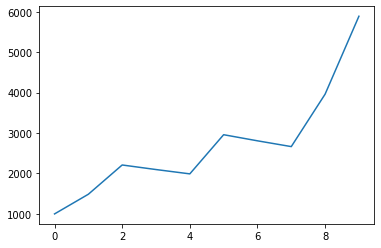

In [3]:
def supertrend_signals(ticker, frequency, multiplier, period, 
                       take_profit, stop_loss, verbose=False, 
                       risk=0.05, date=None, 
                       tp_follow=False, sl_follow=False):

    period = int(period)
    balance = 1000
    ST = 0
    last_ST = 0
    signal = 0
    stance = 0
    take_profit_price = None
    stop_loss_price = None
    entry = None
    entry_date = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []
    balances = [balance]
        
    # TODO: average spread per ticker
    spread = 2.0 / pip_factor(ticker)
    fee_pounds_per_lot = 4

    df = load_ticker(ticker, frequency)
    if date:
        df = df.loc[date]
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)
    SuperTrend(df, period, multiplier)

    for dt, row in df.iterrows():
        signal = 0
        if row[trend_col_name] > 0:
            ST = 1
        elif row[trend_col_name] < 0:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker)
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = (risk * balance) / (stop_loss + spread)
            lots = pounds_per_pip/10.
            fees = lots * fee_pounds_per_lot
            balance += (pounds_per_pip * trade_profit) - fees
            balances.append(balance)
            
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"{entry_date.date()} -> {dt.date()}: Buy : balance = £{balance:,.0f}, {trade_profit:.0f} pips, Lots = {pounds_per_pip/10:.2f}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker)
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = (risk * balance) / (stop_loss + spread)
            lots = pounds_per_pip/10.
            fees = lots * fee_pounds_per_lot
            balance += (pounds_per_pip * trade_profit) - fees    
            balances.append(balance)

            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"{entry_date.date()} -> {dt.date()}: Sell: balance = £{balance:,.0f} {trade_profit:.0f} pips, Lots = {pounds_per_pip/10:.2f}")
                                
                                    
        def open_buy(price, dt):
            nonlocal entry, take_profit_price, stop_loss_price, stance, entry_date
            entry = price
            take_profit_price = entry + (take_profit/pip_factor(ticker))
            stop_loss_price = entry - (stop_loss/pip_factor(ticker))
            stance = 1
            entry_date = dt
            
        def open_sell(price, dt):
            nonlocal entry, take_profit_price, stop_loss_price, stance, entry_date
            entry = price
            take_profit_price = entry - (take_profit/pip_factor(ticker))
            stop_loss_price = entry + (stop_loss/pip_factor(ticker))
            stance = -1
            entry_date = dt
            
            
        if stance > 0:
            if row.High > take_profit_price:
                stance = 0
                close_buy(take_profit_price)
                if tp_follow:
                    open_buy(take_profit_price + spread, dt)
                    
            if row.Low < stop_loss_price:
                stance = 0
                close_buy(stop_loss_price)
                if sl_follow:
                    open_buy(stop_loss_price + spread, dt)

        elif stance < 0:
            if row.Low < take_profit_price:
                stance = 0
                close_sell(take_profit_price)
                if tp_follow:
                    open_sell(take_profit_price + spread, dt)

            if row.High > stop_loss_price:
                stance = 0
                close_sell(stop_loss_price)
                if sl_follow:
                    open_sell(stop_loss_price + spread, dt)

            
        if signal != 0 and stance != signal:
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                open_buy(row.Close + spread, dt)

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                open_sell(row.Close + spread, dt)
                
    win_ratio = 1.*win/(win+loss)

    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {win_ratio:.2}")
        #plt.hist(profits, bins=20)
        plt.plot(balances)
        
    if verbose is True:
        return -balance
    else:
        return -balance * win_ratio

eur_usd_one_hour = {"ticker": "EURUSD", "frequency": 60, 
                    "multiplier": 4.8, "period": 63, "take_profit": 127,  "stop_loss": 42}
gbp_chf_one_hour = {'frequency': 60, 'ticker': 'GBPCHF', 
                    'multiplier': 16.4, 'period': 94.0, 'stop_loss': 20.0, 'take_profit': 195.0}


final_balance = -supertrend_signals(**gbp_chf_one_hour, verbose=True)

months = all_months
monthly_percent_return = (exp(log(final_balance/1000)/months)-1.0)*100

print(f"£{final_balance:,.2f}, {months:.1f} months @ {monthly_percent_return:.1f}%")


### Coarse Search

In [ ]:
def objective(params):
    return supertrend_signals(**params)

space = {'ticker': hp.choice('ticker', ["AUDCAD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 2, 30, 0.1),
         'period': hp.quniform('period', 5, 100, 1),
         'take_profit': hp.quniform('take_profit', 10, 300, 1),
         'stop_loss': hp.quniform('stop_loss', 20, 50, 1),
        }

for _ in range(3):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=5120))


### Grid search for SL + TP

In [ ]:
def find_levels(ticker, frequency, multiplier, period, verbose=False):
    tps = list(range(50, 260, 10))
    sls = list(range(10, 60, 10))
    pfs = np.empty((len(sls), len(tps)))

    for t_idx, tp in enumerate(tps):
        for s_idx, sl in enumerate(sls):
            one_hour["take_profit"] = tp
            one_hour["stop_loss"] = sl
            pf = supertrend_signals(**one_hour, tp_follow=True)
            pfs[s_idx][t_idx] = -pf
    return tps, sls, pfs

In [ ]:
tps, sls, pfs = find_levels(ticker="EURUSD", frequency=60, multiplier=4.8, period=63)

In [ ]:
plt.figure(figsize=(100,10))
fig, ax = plt.subplots()
CS = ax.contour(tps, sls, pfs)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=pfs, x=tps, y=sls)])
fig.show()

### Line search for Period

In [ ]:
periods = range(50, 90, 1)
balances = []
for period in periods:
    balances.append(-supertrend_signals("EURUSD", frequency=60, multiplier=4.8, period=period, 
                          take_profit=127, stop_loss=46, verbose=False, risk=0.05))
plt.plot(periods, balances)

### Line search for Multiplier

In [ ]:
multipliers = [x/10. for x in range(40, 61)]
balances = []
for multiplier in multipliers:
    balances.append(-supertrend_signals("EURUSD", frequency=60, multiplier=multiplier, period=63, 
                          take_profit=127, stop_loss=46, verbose=False, risk=0.05))
plt.plot(multipliers, balances)

### Optimal Risk analysis

In [ ]:
risks = [x/100. for x in range(1, 100)]
balances = []
for risk in risks:
    balances.append(-supertrend_signals(**one_sec, risk=risk))
plt.plot(risks, balances)

##     #return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)   

Balance 5705, 5% risk
print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=63, take_profit=123, stop_loss=21, verbose=False))

#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

### Supertrend SMA

In [ ]:
# Single Supertrend signal
def supertrend_signals_sma(ticker, frequency, multiplier, period, sma_period, take_profit, stop_loss, verbose=False):
    fees = 2.5 # pips
    period = int(period)
    multiplier = int(multiplier)
    sma_period = int(sma_period)
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)

    ST = 0
    last_ST = 0
    signal = 0
    
    stance = 0
    
    take_profit_price = None
    stop_loss_price = None
    entry = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []

    df = load_ticker(ticker, frequency)
    #df = meta_super_trend(df, signal_frequency, period, multiplier)
    SuperTrend(df, period, multiplier)
    sma_name = f"SMA_{sma_period}"
    SMA(df, "Close", sma_name, sma_period)


    for dt, row in df.iterrows():
        signal = 0
        if row[trend_col_name] > 0 and row[sma_name] > row.Close:
            ST = 1
        elif row[trend_col_name] < 0  and row[sma_name] < row.Close:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"{dt}: Close Buy: profit = {trade_profit}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"{dt}: Close Sell: profit = {trade_profit}")
                        
        #potential_exit = row.Close
        
        #if entry is not None and take_profit_price is not None and stop_loss_price is not None:
        if stance > 0:
            if row.High > take_profit_price:
                stance = 0
                #print("Take Profit hit")
                close_buy(take_profit_price)
                    
            if row.Low < stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_buy(stop_loss_price)

        elif stance < 0:
            if row.Low < take_profit_price:
                stance = 0
                #print(f"Take Profit hit {entry}")
                close_sell(take_profit_price)

            if row.High > stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_sell(stop_loss_price)
            
        if signal != 0 and stance != signal:
            # signal = 1 (Buy)
            # stance = -1, 0
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                entry = row.Close
                take_profit_price = entry + (take_profit/pip_factor(ticker))
                stop_loss_price = entry - (stop_loss/pip_factor(ticker))
                stance = 1
                #print(f"Open Buy: entry = {entry}, tp = {take_profit_price}")

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                entry = row.Close
                take_profit_price = entry - (take_profit/pip_factor(ticker))
                stop_loss_price = entry + (stop_loss/pip_factor(ticker))
                stance = -1
                #print(f"Open Sell: entry = {entry}, tp = {take_profit_price}")

                    
    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {1.*win/(win+loss):.2}")
        plt.hist(profits, bins=20)
    return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)    

ticker = "EURUSD"
print(-supertrend_signals_sma(ticker, frequency=60, multiplier=5, period=53, sma_period=10,
                          take_profit=123, stop_loss=70, verbose=True))
#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

# Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

# Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

# Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

In [ ]:
def objective(params):
    return supertrend_signals_sma(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 1, 20, 1),
         'period': hp.quniform('period', 10, 200, 1),
         'sma_period': hp.quniform('sma_period', 10, 200, 1),
         'take_profit': hp.quniform('take_profit', 10, 200, 1),
         'stop_loss': hp.quniform('stop_loss', 10, 200, 1),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=100))

    

## Double supertrend 

In [ ]:
def supertrend_signals_open_close(ticker, frequency, open_multiplier, open_period, close_multiplier, close_period, take_profit, stop_loss, verbose=False):
    fees = 2.5 # pips
    open_period = int(open_period)
    open_multiplier = int(open_multiplier)
    close_period = int(close_period)
    close_multiplier = int(close_multiplier)
    
    open_trend_col_name = 'STX_' + str(open_period) + '_' + str(open_multiplier)
    close_trend_col_name = 'STX_' + str(close_period) + '_' + str(close_multiplier)
    close_value_col_name = 'ST_' + str(close_period) + '_' + str(close_multiplier)

    ST = 0
    last_ST = 0
    last_close = None
    last_close_stance = 0
    signal = 0
    
    stance = 0
    
    take_profit_price = None
    stop_loss_price = None
    entry = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []

    df = load_ticker(ticker, frequency)
    
    SuperTrend(df, open_period, open_multiplier)
    SuperTrend(df, close_period, close_multiplier)


    for dt, row in df.iterrows():
        signal = 0
        if row[open_trend_col_name] > 0:
            ST = 1
        elif row[open_trend_col_name] < 0:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"Close Buy: profit = {trade_profit}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"Close Sell: profit = {trade_profit}")
                        
        if stance > 0:
            if last_close_stance != stance:
                close_buy(row.Close)
                    
            if row.High > take_profit_price:
                stance = 0
                #print("Take Profit hit")
                close_buy(take_profit_price)
                    
            if row.Low < stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_buy(stop_loss_price)

        elif stance < 0:
            if last_close_stance != stance:
                close_sell(row.Close)
                    
            elif row.Low < take_profit_price:
                stance = 0
                #print(f"Take Profit hit {entry}")
                close_sell(take_profit_price)

            elif row.High > stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_sell(stop_loss_price)
            
        if signal != 0 and stance != signal:
            # signal = 1 (Buy)
            # stance = -1, 0
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                entry = row.Close
                take_profit_price = entry + (take_profit/pip_factor(ticker))
                stop_loss_price = entry - (stop_loss/pip_factor(ticker))
                stance = 1
                #print(f"Open Buy: entry = {entry}, tp = {take_profit_price}")

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                entry = row.Close
                take_profit_price = entry - (take_profit/pip_factor(ticker))
                stop_loss_price = entry + (stop_loss/pip_factor(ticker))
                stance = -1
                #print(f"Open Sell: entry = {entry}, tp = {take_profit_price}")
                
        last_close = row[close_value_col_name]
        last_close_stance = row[close_trend_col_name]

                    
    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {1.*win/(win+loss):.2}")
        plt.hist(profits, bins=20)
    return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)    

ticker = "EURUSD"
print(-supertrend_signals_open_close(ticker, frequency=60, open_multiplier=5, open_period=54, 
                          close_multiplier=5, close_period=54,
                          take_profit=123, stop_loss=75, verbose=True))
#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

# Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

# Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

# Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

In [ ]:
def objective(params):
    return supertrend_signals_open_close(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60*24]),
         'open_multiplier': hp.quniform('open_multiplier', 1, 20, 1),
         'open_period': hp.quniform('open_period', 10, 200, 10),
         'close_multiplier': hp.quniform('close_multiplier', 1, 20, 1),
         'close_period': hp.quniform('close_period', 10, 200, 10),
         'take_profit': hp.quniform('take_profit', 10, 200, 10),
         'stop_loss': hp.quniform('stop_loss', 10, 200, 10),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=1000))

    

### Supertrend and double moving average crossover

In [ ]:

ticker = "EURUSD"

def supertrend_sma_signals(ticker, frequency, multiplier, period, sma_period):
    fees = 2.5 # pips
    period = int(period)
    multiplier = int(multiplier)
    sma_period = int(sma_period)

    

    last_val = 0.0
    entry = None
    profit_pips = 0.0
    
    df = load_ticker(ticker, frequency)
    SuperTrend(df, period, multiplier)
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)
    sma_name = f"SMA_{sma_period}"
    df = SMA(df, "Close", sma_name, sma_period)


    for dt, row in df.iterrows():
        stance = 0
        if row[trend_col_name] > 0 and row.Close > row[sma_name]:
            stance = 1
        elif row[trend_col_name] < 0 and row.Close < row[sma_name]:
            stance = -1
            
        if stance != last_val:
            # Stance has changed
            if stance > last_val:
                # Sell to neutral
                # Sell to buy
                # Neutral to buy
                if last_val < 0.0 and entry is not None:
                    # Sell to something
                    # Exit the sell
                    profit_pips += (entry - row.Close) * pip_factor(ticker) - fees
                if stance > 0.0:
                    # Something to buy
                    # Take a long position
                    entry = row.Close
                
            if stance < last_val:
                if last_val > 0.0 and entry is not None:
                    profit_pips += (row.Close - entry) * pip_factor(ticker) - fees
                    
                if stance < 0.0:
                    entry = row.Close
        last_val = stance
    return -profit_pips    

print(-supertrend_sma_signals(ticker, 60, 50, 5, 100))

In [ ]:
def objective(params):
    return supertrend_sma_signals(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 1, 20, 1),
         'period': hp.quniform('period', 1, 100, 1),
         'sma_period': hp.quniform('sma_period', 20, 200, 10),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=100))

    

In [ ]:
def meta_super_trend(df, sample_mins, period, multiplier):

    ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last'}
    base_interval = (df.index[1]-df.index[0]).components.minutes
    dfs = []
    for base in range(0, sample_mins, base_interval):
        tmp = df.resample(f"{sample_mins}Min", base=base).apply(ohlc_dict).dropna()
        SuperTrend(tmp, period, multiplier, prefix=sample_mins)
        dfs.append(tmp)

    return pd.concat(dfs).sort_index()